In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,RobustScaler
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,auc


from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder

In [714]:
train = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/Train.csv')
test = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/test_l0Auv8Q.csv')

camp1 = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/First_Health_Camp_Attended.csv')
camp2 = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/Second_Health_Camp_Attended.csv')
camp3 = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/Third_Health_Camp_Attended.csv')
camp_detail = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/Health_Camp_Detail.csv')
patient_profile = pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/Patient_Profile.csv')
submission=pd.read_csv('D:/PGDBA/Z1. Competitions/AV - Healthcare Analytics/sample_submmission.csv')

In [715]:
train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7


In [718]:
camp1.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN
2,518680,6560,10,0.048780,NaN
3,509916,6560,30,0.634146,NaN
4,488006,6560,20,0.024390,NaN


In [719]:
camp1.drop(columns=['Unnamed: 4'],axis=1,inplace=True)

In [720]:
camp2.head()

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700
2,498864,6536,0.673181
3,515398,6536,0.722041
4,504624,6536,0.464712


In [721]:
camp3.head()

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1
2,504692,6527,3,1
3,493167,6527,4,4
4,510954,6528,2,2


In [722]:
camp3=camp3[camp3.Number_of_stall_visited>0]
camp3.Number_of_stall_visited.value_counts()

1    1822
2    1243
3    1145
5    1034
4     701
6     536
7      16
Name: Number_of_stall_visited, dtype: int64

In [723]:
all_camps=pd.concat([camp1,camp2,camp3],sort=False)
all_camps['outcome']=1
all_camps=all_camps.fillna(0)

In [724]:
all_camps.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,outcome
0,506181,6560,40.0,0.439024,0.0,0.0,0.0,1
1,494977,6560,20.0,0.097561,0.0,0.0,0.0,1
2,518680,6560,10.0,0.048780,0.0,0.0,0.0,1
3,509916,6560,30.0,0.634146,0.0,0.0,0.0,1
4,488006,6560,20.0,0.024390,0.0,0.0,0.0,1


In [725]:
camp_detail.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1


In [726]:
patient_profile.head()

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry
2,508307,0,0,0,0,3,87,46,02-Nov-02,D,BFSI
3,512612,0,0,0,0,1,75,47,02-Nov-02,D,Education
4,521075,0,0,0,0,3,None,80,24-Nov-02,H,Others


In [727]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())
print(camp1.isna().sum().sum())
print(camp2.isna().sum().sum())
print(camp3.isna().sum().sum())
print(camp_detail.isna().sum().sum())
print(patient_profile.isna().sum().sum())

334
0
0
0
0
0
58177


In [728]:
train.isna().sum()

Patient_ID             0
Health_Camp_ID         0
Registration_Date    334
Var1                   0
Var2                   0
Var3                   0
Var4                   0
Var5                   0
dtype: int64

In [729]:
patient_profile.isna().sum()

Patient_ID               0
Online_Follower          0
LinkedIn_Shared          0
Twitter_Shared           0
Facebook_Shared          0
Income                   0
Education_Score          0
Age                      0
First_Interaction        0
City_Type            23384
Employer_Category    34793
dtype: int64

In [730]:
train_merge = pd.merge(train, patient_profile, on='Patient_ID', how='left')
test_merge = pd.merge(test, patient_profile, on='Patient_ID', how='left')

In [731]:
train_merge.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,489652,6578,10-Sep-05,4,0,0,0,2,0,0,0,0,None,None,None,06-Dec-04,NaN,NaN
1,507246,6578,18-Aug-05,45,5,0,0,7,0,0,0,0,1,75,40,08-Sep-04,C,Others
2,523729,6534,29-Apr-06,0,0,0,0,0,0,0,0,0,None,None,None,22-Jun-04,NaN,NaN
3,524931,6535,07-Feb-04,0,0,0,0,0,0,0,0,0,None,None,None,07-Feb-04,I,NaN
4,521364,6529,28-Feb-06,15,1,0,0,7,0,0,0,1,1,70,40,04-Jul-03,I,Technology


In [732]:
train_merge['Registration_Date']=train_merge['Registration_Date'].fillna(train_merge['First_Interaction'])

In [733]:
train_merge= pd.merge(train_merge,all_camps,on=['Patient_ID', 'Health_Camp_ID'], how='left')
test_merge = pd.merge(test_merge,all_camps,on=['Patient_ID', 'Health_Camp_ID'], how='left')
train_merge['outcome'] = train_merge['outcome'].fillna(0).astype('int')
test_merge.drop(columns=['outcome'],axis=1,inplace=True)

In [734]:
train_merge.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,outcome
0,489652,6578,10-Sep-05,4,0,0,0,2,0,0,...,None,06-Dec-04,NaN,NaN,0.0,0.0,0.000000,2.0,1.0,1
1,507246,6578,18-Aug-05,45,5,0,0,7,0,0,...,40,08-Sep-04,C,Others,NaN,NaN,NaN,NaN,NaN,0
2,523729,6534,29-Apr-06,0,0,0,0,0,0,0,...,None,22-Jun-04,NaN,NaN,0.0,0.0,0.402054,0.0,0.0,1
3,524931,6535,07-Feb-04,0,0,0,0,0,0,0,...,None,07-Feb-04,I,NaN,NaN,NaN,NaN,NaN,NaN,0
4,521364,6529,28-Feb-06,15,1,0,0,7,0,0,...,40,04-Jul-03,I,Technology,0.0,0.0,0.845597,0.0,0.0,1


In [735]:
train_merge= pd.merge(train_merge,camp_detail,on=['Health_Camp_ID'], how='left')
test_merge = pd.merge(test_merge,camp_detail,on=['Health_Camp_ID'], how='left')

In [736]:
train_merge.fillna(-99,inplace=True)
test_merge.fillna(-99,inplace=True)

In [737]:
train_merge.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,...,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,outcome,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,489652,6578,10-Sep-05,4,0,0,0,2,0,0,...,0.0,0.000000,2.0,1.0,1,16-Aug-05,14-Oct-05,Third,G,2
1,507246,6578,18-Aug-05,45,5,0,0,7,0,0,...,-99.0,-99.000000,-99.0,-99.0,0,16-Aug-05,14-Oct-05,Third,G,2
2,523729,6534,29-Apr-06,0,0,0,0,0,0,0,...,0.0,0.402054,0.0,0.0,1,17-Oct-05,07-Nov-07,Second,A,2
3,524931,6535,07-Feb-04,0,0,0,0,0,0,0,...,-99.0,-99.000000,-99.0,-99.0,0,01-Feb-04,18-Feb-04,First,E,2
4,521364,6529,28-Feb-06,15,1,0,0,7,0,0,...,0.0,0.845597,0.0,0.0,1,30-Mar-06,03-Apr-06,Second,A,2


In [738]:
train_merge.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
       'Var3', 'Var4', 'Var5', 'Online_Follower', 'LinkedIn_Shared',
       'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age',
       'First_Interaction', 'City_Type', 'Employer_Category', 'Donation',
       'Health_Score', 'Health Score', 'Number_of_stall_visited',
       'Last_Stall_Visited_Number', 'outcome', 'Camp_Start_Date',
       'Camp_End_Date', 'Category1', 'Category2', 'Category3'],
      dtype='object')

In [739]:
train_merge['Registration_Date']  = pd.to_datetime(train_merge['Registration_Date'])
train_merge['First_Interaction']  = pd.to_datetime(train_merge['First_Interaction'])
train_merge['Camp_Start_Date']    = pd.to_datetime(train_merge['Camp_Start_Date'])
train_merge['Camp_End_Date']      = pd.to_datetime(train_merge['Camp_End_Date']) 

test_merge['Registration_Date']  = pd.to_datetime(test_merge['Registration_Date'])
test_merge['First_Interaction']  = pd.to_datetime(test_merge['First_Interaction'])
test_merge['Camp_Start_Date']    = pd.to_datetime(test_merge['Camp_Start_Date'])
test_merge['Camp_End_Date']      = pd.to_datetime(test_merge['Camp_End_Date']) 

In [740]:
train_merge.dtypes

Patient_ID                            int64
Health_Camp_ID                        int64
Registration_Date            datetime64[ns]
Var1                                  int64
Var2                                  int64
Var3                                  int64
Var4                                  int64
Var5                                  int64
Online_Follower                       int64
LinkedIn_Shared                       int64
Twitter_Shared                        int64
Facebook_Shared                       int64
Income                               object
Education_Score                      object
Age                                  object
First_Interaction            datetime64[ns]
City_Type                            object
Employer_Category                    object
Donation                            float64
Health_Score                        float64
Health Score                        float64
Number_of_stall_visited             float64
Last_Stall_Visited_Number       

In [741]:
train_merge.loc[train_merge['Age'] == 'None', 'Age'] = -9999
test_merge.loc[test_merge['Age'] == 'None', 'Age'] = -9999
train_merge['Age']      = train_merge['Age'].astype(np.float32) 
test_merge['Age']       = test_merge['Age'].astype(np.float32)

train_merge.loc[train_merge['Education_Score'] == 'None', 'Education_Score'] = -9999
test_merge.loc[test_merge['Education_Score'] == 'None', 'Education_Score'] = -9999
train_merge['Education_Score']      = train_merge['Education_Score'].astype(np.float32) 
test_merge['Education_Score']       = test_merge['Education_Score'].astype(np.float32)

In [742]:
train_merge.dtypes

Patient_ID                            int64
Health_Camp_ID                        int64
Registration_Date            datetime64[ns]
Var1                                  int64
Var2                                  int64
Var3                                  int64
Var4                                  int64
Var5                                  int64
Online_Follower                       int64
LinkedIn_Shared                       int64
Twitter_Shared                        int64
Facebook_Shared                       int64
Income                               object
Education_Score                     float32
Age                                 float32
First_Interaction            datetime64[ns]
City_Type                            object
Employer_Category                    object
Donation                            float64
Health_Score                        float64
Health Score                        float64
Number_of_stall_visited             float64
Last_Stall_Visited_Number       

In [743]:
train_merge.isna().sum().sum()

0

In [744]:
test_merge.isna().sum().sum()

0

# Feature Engineering

In [745]:
train_merge[['City_Type','Employer_Category','Income','Category1','Category2']].head()

,City_Type,Employer_Category,Income,Category1,Category2
0,-99,-99,None,Third,G
1,C,Others,1,Third,G
2,-99,-99,None,Second,A
3,I,-99,None,First,E
4,I,Technology,1,Second,A


In [747]:
cat_fetaures=['City_Type','Employer_Category','Income','Category1','Category2']
le = TargetEncoder()
le.fit(train_merge[cat_fetaures],train_merge['outcome'])
train_merge[cat_fetaures] = le.transform(train_merge[cat_fetaures])
test_merge[cat_fetaures] = le.transform(test_merge[cat_fetaures])

In [748]:
train_merge[['City_Type','Employer_Category','Income','Category1','Category2']].head()

,City_Type,Employer_Category,Income,Category1,Category2
0,0.215761,0.257911,0.247955,0.632496,0.632496
1,0.327542,0.342564,0.343808,0.632496,0.632496
2,0.215761,0.257911,0.247955,0.517335,0.494769
3,0.323370,0.257911,0.247955,0.124629,0.103631
4,0.323370,0.336824,0.343808,0.517335,0.494769


In [749]:
train_merge['Social_Media'] = ((train_merge['Online_Follower'] == 1) | (train_merge['Facebook_Shared'] == 1) | (train_merge['Twitter_Shared'] == 1) | (train_merge['LinkedIn_Shared'] == 1)).astype('int')
test_merge['Social_Media'] = ((test_merge['Online_Follower'] == 1) | (test_merge['Facebook_Shared'] == 1) | (test_merge['Twitter_Shared'] == 1) | (test_merge['LinkedIn_Shared'] == 1)).astype('int')

drop_cols = ['Online_Follower', 'Facebook_Shared', 'Twitter_Shared', 'LinkedIn_Shared']
train_merge = train_merge.drop(drop_cols, axis = 1)    
test_merge = test_merge.drop(drop_cols, axis = 1)

In [750]:
train_merge['Camp_Duration'] = ((train_merge['Camp_End_Date'] - train_merge['Camp_Start_Date']).dt.days).astype(np.float32)
test_merge['Camp_Duration'] = ((test_merge['Camp_End_Date'] - test_merge['Camp_Start_Date']).dt.days).astype(np.float32)
    
train_merge['CampEnd_diff_Registration'] = ((train_merge['Camp_End_Date'] - train_merge['Registration_Date']).dt.days).astype(np.float32)
test_merge['CampEnd_diff_Registration'] = ((test_merge['Camp_End_Date'] - test_merge['Registration_Date']).dt.days).astype(np.float32)
   
train_merge['CampStart_diff_Registration'] = ((train_merge['Camp_Start_Date'] - train_merge['Registration_Date']).dt.days).astype(np.float32)
test_merge['CampStart_diff_Registration'] = ((test_merge['Camp_Start_Date'] - test_merge['Registration_Date']).dt.days).astype(np.float32)   
   
train_merge['CampEnd_diff_First'] = ((train_merge['Camp_End_Date'] - train_merge['First_Interaction']).dt.days).astype(np.float32)
test_merge['CampEnd_diff_First'] = ((test_merge['Camp_End_Date'] - test_merge['First_Interaction']).dt.days).astype(np.float32)      
   
train_merge['CampStart_diff_First'] = ((train_merge['Camp_Start_Date'] - train_merge['First_Interaction']).dt.days).astype(np.float32)
test_merge['CampStart_diff_First'] = ((test_merge['Camp_Start_Date'] - test_merge['First_Interaction']).dt.days).astype(np.float32)         
            
train_merge['Registration_diff_First'] = ((train_merge['Registration_Date'] - train_merge['First_Interaction']).dt.days).astype(np.float32)
test_merge['Registration_diff_First'] = ((test_merge['Registration_Date'] - test_merge['First_Interaction']).dt.days).astype(np.float32)  

train_merge['ratio_end_reg_duration'] = (train_merge['CampEnd_diff_Registration'] / train_merge['Camp_Duration'])
test_merge['ratio_end_reg_duration'] = (test_merge['CampEnd_diff_Registration'] / test_merge['Camp_Duration'])


train_merge['Reg_year'] = train_merge['Registration_Date'].dt.year
train_merge['Reg_day'] = train_merge['Registration_Date'].dt.day
train_merge['Reg_month'] = train_merge['Registration_Date'].dt.month
train_merge['Reg_dayofweek'] = train_merge['Registration_Date'].dt.dayofweek
train_merge['Reg_weekofyear'] = train_merge['Registration_Date'].dt.weekofyear

test_merge['Reg_year'] = test_merge['Registration_Date'].dt.year
test_merge['Reg_day'] = test_merge['Registration_Date'].dt.day
test_merge['Reg_month'] = test_merge['Registration_Date'].dt.month
test_merge['Reg_dayofweek'] = test_merge['Registration_Date'].dt.dayofweek
test_merge['Reg_weekofyear'] = test_merge['Registration_Date'].dt.weekofyear

train_merge['campstart_year'] = train_merge['Camp_Start_Date'].dt.year
train_merge['campstart_day'] = train_merge['Camp_Start_Date'].dt.day
train_merge['campstart_month'] = train_merge['Camp_Start_Date'].dt.month
train_merge['campstart_dayofweek'] = train_merge['Camp_Start_Date'].dt.dayofweek
train_merge['campstart_weekofyear'] = train_merge['Camp_Start_Date'].dt.weekofyear

test_merge['campstart_year'] = test_merge['Camp_Start_Date'].dt.year
test_merge['campstart_day'] = test_merge['Camp_Start_Date'].dt.day
test_merge['campstart_month'] = test_merge['Camp_Start_Date'].dt.month
test_merge['campstart_dayofweek'] = test_merge['Camp_Start_Date'].dt.dayofweek
test_merge['campstart_weekofyear'] = test_merge['Camp_Start_Date'].dt.weekofyear

train_merge['campend_year'] = train_merge['Camp_End_Date'].dt.year
train_merge['campend_day'] = train_merge['Camp_End_Date'].dt.day
train_merge['campend_month'] = train_merge['Camp_End_Date'].dt.month
train_merge['campend_dayofweek'] = train_merge['Camp_End_Date'].dt.dayofweek
train_merge['campend_weekofyear'] = train_merge['Camp_End_Date'].dt.weekofyear

test_merge['campend_year'] = test_merge['Camp_End_Date'].dt.year
test_merge['campend_day'] = test_merge['Camp_End_Date'].dt.day
test_merge['campend_month'] = test_merge['Camp_End_Date'].dt.month
test_merge['campend_dayofweek'] = test_merge['Camp_End_Date'].dt.dayofweek
test_merge['campend_weekofyear'] = test_merge['Camp_End_Date'].dt.weekofyear

In [752]:
year_fetaures=['Reg_year','campstart_year','campend_year']

for col in year_fetaures:
    enc = LabelEncoder()
    full_list = list(train_merge[col].values) + list(test_merge[col].values)
    enc.fit(full_list)
    train_merge[col] = enc.transform(list(train_merge[col].values))
    test_merge[col]  = enc.transform(list(test_merge[col].values))

In [754]:
date_features=['Registration_Date','Camp_Start_Date','First_Interaction','Camp_End_Date']
train_merge.drop(columns=date_features,axis=1,inplace=True)
test_merge.drop(columns=date_features,axis=1,inplace=True)

In [756]:
train_merge['Age_bins']=pd.cut(train_merge['Age'],[-10000,20,30,40,80],labels=[4,3,2,1])
test_merge['Age_bins']=pd.cut(test_merge['Age'],[-10000,20,30,40,80],labels=[4,3,2,1])

In [757]:
train_merge['Age_bins']=train_merge['Age_bins'].astype('int')
test_merge['Age_bins']=test_merge['Age_bins'].astype('int')

In [758]:
def getCountVar(compute_df, count_df, var_name, count_var="v1"):
    grouped_df = count_df.groupby(var_name, as_index=False).agg('size').reset_index()
    grouped_df.columns = [var_name, "var_count"]
    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(-1, inplace=True)
    return list(merged_df["var_count"])

In [759]:
for col in ["Patient_ID", "Health_Camp_ID"]:
    full_df = pd.concat([train_merge, test_merge])
    train_merge["Count_"+col] = getCountVar(train, full_df, col)
    test_merge["Count_"+col] = getCountVar(test, full_df, col)

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


# Model Building

In [760]:
X_train =  train_merge.drop(['outcome','Patient_ID','Health_Camp_ID'], axis = 1)
X_test  =  test_merge.drop(['Patient_ID','Health_Camp_ID'], axis = 1)
y_train  =  train_merge['outcome']

In [761]:
X_train =  X_train.drop(['Donation','Health_Score','Health Score','Number_of_stall_visited','Last_Stall_Visited_Number'], axis = 1)
X_test  =  X_test.drop(['Donation','Health_Score','Health Score','Number_of_stall_visited','Last_Stall_Visited_Number'], axis = 1)

In [762]:
def create_folds(X_train, y_train, n_folds):
    
    # Create cv split
    kfolds = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 0)
    train_indices = []
    validation_indices = []
    for train_index, validation_index in kfolds.split(X_train, y_train):
        train_indices.append(train_index)
        validation_indices.append(validation_index)
        
    return train_indices, validation_indices

In [763]:
train_indices, validation_indices = create_folds(X_train, y_train, 5)

In [798]:
xgb_param= {'objective': 'binary:logistic', 
            'eta': 0.02 , 
            'eval_metric' : 'auc',
            'subsample': 0.8 , 'min_child_weight': 5, 'max_depth': 6 , 'colsample_bytree': 0.7, 'silent':1,'seed': 0}

lgb_param={'reg_lambda': 0.1,
 'reg_alpha': 0.3,
 'num_leaves': 1400,
 'min_split_gain': 0.001,
 'min_data_in_leaf': 60,
 'min_child_weight': 0.001,
 'max_depth': 40,
 'learning_rate': 0.3944206059437656,
 'feature_fraction': 0.5,
 'bagging_frequency': 1,
 'bagging_fraction': 0.8}


xgb_base=xgb.XGBClassifier()
xgb_tuned=xgb.XGBClassifier(**xgb_param)
lgb_base=lgb.LGBMClassifier()
lgb_tuned=lgb.LGBMClassifier(**lgb_param)


models2=[xgb_base,xgb_tuned,lgb_base,lgb_tuned]
metric2=[]
metric_kfold=[]

for model in models2:
            print("Training {}".format(str(model).split('(')[0]))
            predictions = np.zeros(X_train.shape[0], dtype = np.float64)
            for i in range(0, 5): 
                model.fit(X_train.iloc[train_indices[i]], y_train[train_indices[i]])           
                predictions[validation_indices[i]] = [x[1] for x in model.predict_proba(X_train.iloc[validation_indices[i]])]
                m=round(roc_auc_score(y_train[validation_indices[i]], predictions[validation_indices[i]]), 4)
                metric_kfold.append(m)
            metric2.append(np.mean(metric_kfold))
            metric_kfold=[]

ensemble_1=pd.DataFrame({'names':['XGBoost (Base)','XGBoost (Tuned)','LGBM (Base)', 'LGBM (Tuned)'],
                       'ROC':metric2})

ensemble_1=ensemble_1.sort_values(by='ROC',ascending=False).reset_index(drop=True)

ensemble_1

Training XGBClassifier
Training XGBClassifier
Training LGBMClassifier
Training LGBMClassifier


,names,ROC
0,LGBM (Tuned),0.88868
1,LGBM (Base),0.87300
2,XGBoost (Tuned),0.87286
3,XGBoost (Base),0.86282


In [766]:
preds = 0

for seed_val, num_rounds in [[0,200], [2016,250], [1323, 225]]:
    xgb_param= {'objective': 'binary:logistic', 
            'eta': 0.02 , 
            'eval_metric' : 'auc',
            'subsample': 0.8 , 'min_child_weight': 5, 'max_depth': 6 , 'colsample_bytree': 0.7, 'silent':1,'seed': seed_val}

    xgtest = xgb.DMatrix(X_test)
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    
    model = xgb.train(xgb_param, xgtrain, num_rounds)
    temp_preds = model.predict(xgtest)
    preds += temp_preds

preds=preds/3

C:\Users\Ashish\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Ashish\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


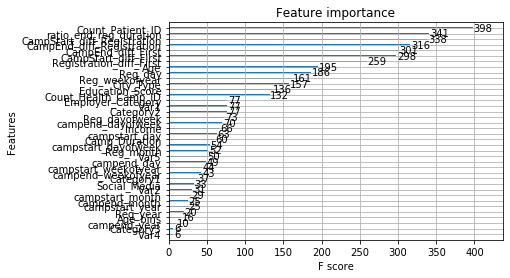

In [827]:
xgb.plot_importance(xgb_tuned)

In [801]:
final_prediction_lgbb=lgb_base.predict_proba(X_test)[:,1]
final_prediction_xgbb=xgb_base.predict_proba(X_test)[:,1]
final_prediction_xgbt=xgb_tuned.predict_proba(X_test)[:,1]
final_prediction_lgbt=lgb_tuned.predict_proba(X_test)[:,1]

In [817]:
overall_prediction=((final_prediction_lgbb)+(final_prediction_xgbt))/(2)

In [818]:
submission['Outcome']=overall_prediction

In [819]:
submission.head()

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.512729
1,500633,6584,0.439488
2,506945,6582,0.222567
3,497447,6551,0.818440
4,496446,6533,0.054462


In [816]:
submission.to_csv('C:/Users/Ashish/Downloads/AV_Healthcare_Sub28.csv',index=False)